In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import astropy
from astropy.io import fits
from astropy.coordinates import SkyCoord

from simla_variables import SimlaVar
from simladb import query, simladb, DB_bcd, DB_bcdwise, DB_shardpos, scorners
from simla_utils import fmt_scorners, zoom_image
import validation_funcs

/Users/grant/anaconda3/envs/simlaenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sl_n_shards = SimlaVar().sl_n_shards
ll_n_shards = SimlaVar().ll_n_shards
simlapath = SimlaVar().simlapath
plotpath = simlapath+'validations/plots/'
irspath = SimlaVar().irspath
wisepath = SimlaVar().wisepath

# BCD Edge Trimming
Look at the superdarks so we can see where the bad pixels on the edges are

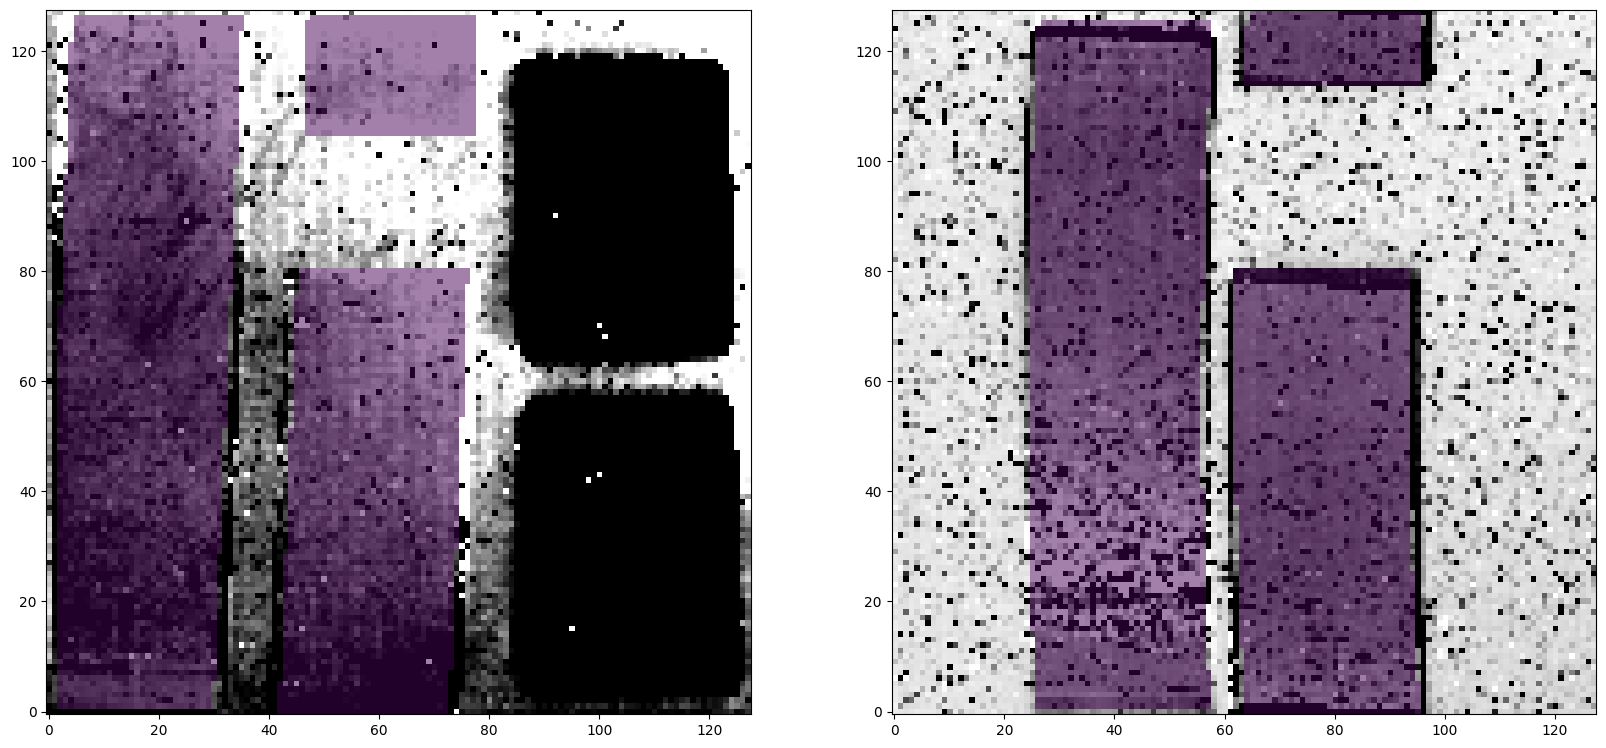

In [3]:
sl_sd, ll_sd = \
    np.load(simlapath+'superdarks/superdarks/superdark_SL_ramp-60.95_fidzodi-14.3.npy')[0], \
    np.load(simlapath+'superdarks/superdarks/superdark_LL_ramp-14.68_fidzodi-14.3.npy')[0]

sl_mask_lib, ll_mask_lib = \
    [np.load(simlapath+'calib/trimmed_fullslit_masks/SL1.npy'), np.load(simlapath+'calib/trimmed_fullslit_masks/SL2.npy'),  \
                                                                np.load(simlapath+'calib/trimmed_fullslit_masks/SL3.npy')], \
    [np.load(simlapath+'calib/trimmed_fullslit_masks/LL1.npy'), np.load(simlapath+'calib/trimmed_fullslit_masks/LL2.npy'),  \
                                                                np.load(simlapath+'calib/trimmed_fullslit_masks/LL3.npy')]
sl_fullmask, ll_fullmask = \
    np.where(np.sum(sl_mask_lib, axis=0)==0, np.nan, 1), np.where(np.sum(ll_mask_lib, axis=0)==0, np.nan, 1)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(sl_sd, origin='lower', interpolation='none', vmin=-5, vmax=5, cmap='gray_r')
plt.imshow(sl_fullmask, origin='lower', interpolation='none', alpha=0.5)

plt.subplot(1, 2, 2)
plt.imshow(ll_sd, origin='lower', interpolation='none', vmin=-5, vmax=30, cmap='gray_r')
plt.imshow(ll_fullmask, origin='lower', interpolation='none', alpha=0.5)

plt.savefig(plotpath+'shard_masks/trimmed_masks.pdf', format='pdf')
plt.show()

# Shard Masks with Nod Positions

In [4]:
sl1_nods = [[], [], []]
for i in range(128):
    row = sl_mask_lib[0][i]
    onorder_width = int(np.sum(row))
    if onorder_width > 0:
        nod1, nod2 = np.where(row==1)[0][0] + (onorder_width * (1/3)), np.where(row==1)[0][0] + (onorder_width * (2/3))
        sl1_nods[0].append(i)
        sl1_nods[1].append(nod1)
        sl1_nods[2].append(nod2)

sl2_nods = [[], [], []]
for i in range(128):
    row = sl_mask_lib[1][i]
    onorder_width = int(np.sum(row))
    if onorder_width > 0:
        nod1, nod2 = np.where(row==1)[0][0] + (onorder_width * (1/3)), np.where(row==1)[0][0] + (onorder_width * (2/3))
        sl2_nods[0].append(i)
        sl2_nods[1].append(nod1)
        sl2_nods[2].append(nod2)

sl3_nods = [[], [], []]
for i in range(128):
    row = sl_mask_lib[2][i]
    onorder_width = int(np.sum(row))
    if onorder_width > 0:
        nod1, nod2 = np.where(row==1)[0][0] + (onorder_width * (1/3)), np.where(row==1)[0][0] + (onorder_width * (2/3))
        sl3_nods[0].append(i)
        sl3_nods[1].append(nod1)
        sl3_nods[2].append(nod2)

ll1_nods = [[], [], []]
for i in range(128):
    row = ll_mask_lib[0][i]
    onorder_width = int(np.sum(row))
    if onorder_width > 0:
        nod1, nod2 = np.where(row==1)[0][0] + (onorder_width * (1/3)), np.where(row==1)[0][0] + (onorder_width * (2/3))
        ll1_nods[0].append(i)
        ll1_nods[1].append(nod1)
        ll1_nods[2].append(nod2)

ll2_nods = [[], [], []]
for i in range(128):
    row = ll_mask_lib[1][i]
    onorder_width = int(np.sum(row))
    if onorder_width > 0:
        nod1, nod2 = np.where(row==1)[0][0] + (onorder_width * (1/3)), np.where(row==1)[0][0] + (onorder_width * (2/3))
        ll2_nods[0].append(i)
        ll2_nods[1].append(nod1)
        ll2_nods[2].append(nod2)

ll3_nods = [[], [], []]
for i in range(128):
    row = ll_mask_lib[2][i]
    onorder_width = int(np.sum(row))
    if onorder_width > 0:
        nod1, nod2 = np.where(row==1)[0][0] + (onorder_width * (1/3)), np.where(row==1)[0][0] + (onorder_width * (2/3))
        ll3_nods[0].append(i)
        ll3_nods[1].append(nod1)
        ll3_nods[2].append(nod2)

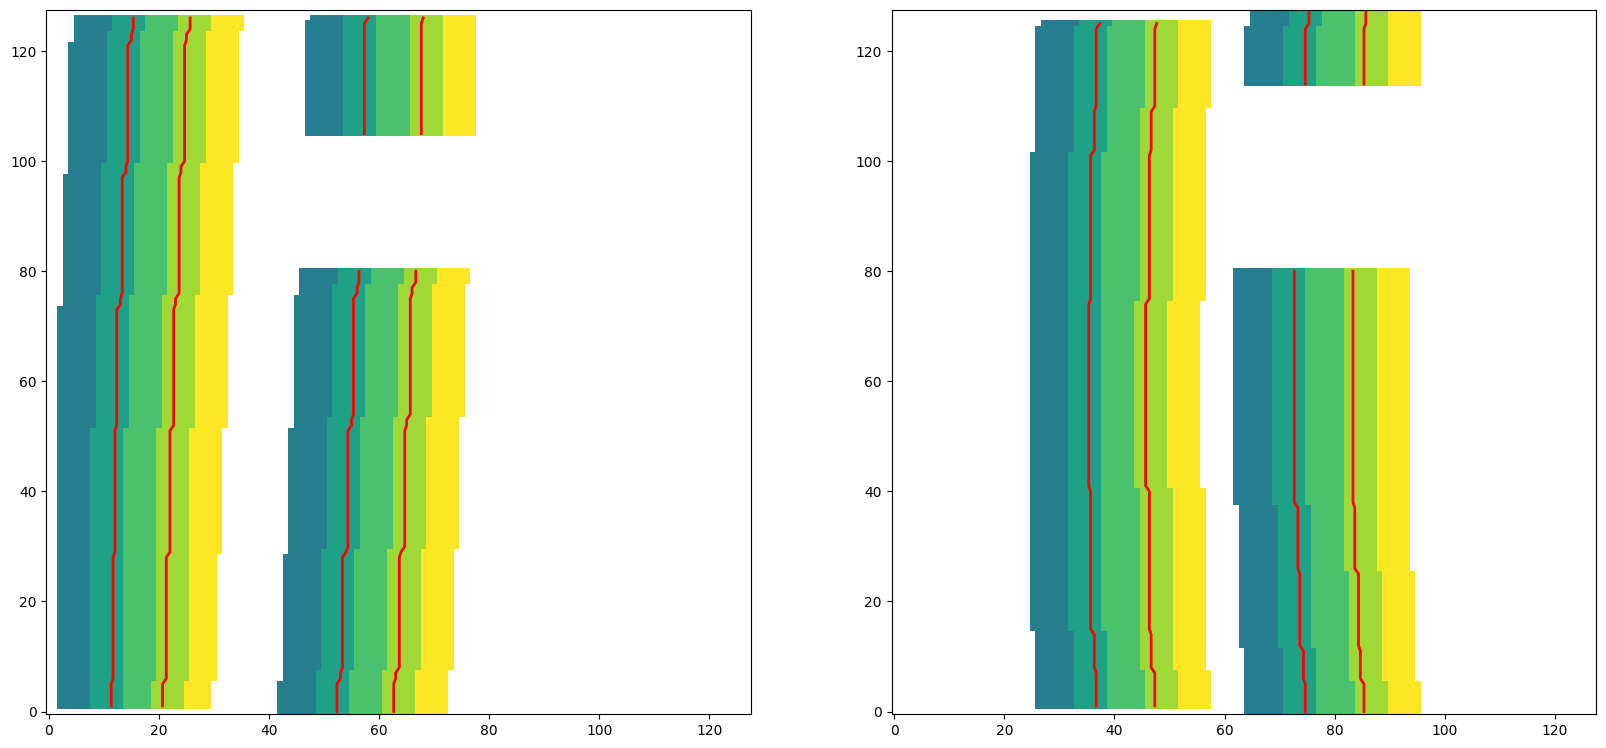

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(1, 2, 1)
plot = sl_fullmask
shardmasks = np.load(simlapath+'calib/shard_masks/SL1.npy')
for i in range(sl_n_shards):
    plot = np.where(shardmasks[i]==1, i+3, plot)
shardmasks = np.load(simlapath+'calib/shard_masks/SL2.npy')
for i in range(sl_n_shards):
    plot = np.where(shardmasks[i]==1, i+3, plot)
shardmasks = np.load(simlapath+'calib/shard_masks/SL3.npy')
for i in range(sl_n_shards):
    plot = np.where(shardmasks[i]==1, i+3, plot)
plot = np.where(plot==0, np.nan, plot)
plt.plot(sl1_nods[1], sl1_nods[0], color='red', lw=2)
plt.plot(sl1_nods[2], sl1_nods[0], color='red', lw=2)
plt.plot(sl2_nods[1], sl2_nods[0], color='red', lw=2)
plt.plot(sl2_nods[2], sl2_nods[0], color='red', lw=2)
plt.plot(sl3_nods[1], sl3_nods[0], color='red', lw=2)
plt.plot(sl3_nods[2], sl3_nods[0], color='red', lw=2)
plt.imshow(plot, origin='lower', interpolation='none', vmin=0)

plt.subplot(1, 2, 2)
plot = ll_fullmask
shardmasks = np.load(simlapath+'calib/shard_masks/LL1.npy')
for i in range(ll_n_shards):
    plot = np.where(shardmasks[i]==1, i+3, plot)
shardmasks = np.load(simlapath+'calib/shard_masks/LL2.npy')
for i in range(ll_n_shards):
    plot = np.where(shardmasks[i]==1, i+3, plot)
shardmasks = np.load(simlapath+'calib/shard_masks/LL3.npy')
for i in range(ll_n_shards):
    plot = np.where(shardmasks[i]==1, i+3, plot)
plot = np.where(plot==0, np.nan, plot)
plt.plot(ll1_nods[1], ll1_nods[0], color='red', lw=2)
plt.plot(ll1_nods[2], ll1_nods[0], color='red', lw=2)
plt.plot(ll2_nods[1], ll2_nods[0], color='red', lw=2)
plt.plot(ll2_nods[2], ll2_nods[0], color='red', lw=2)
plt.plot(ll3_nods[1], ll3_nods[0], color='red', lw=2)
plt.plot(ll3_nods[2], ll3_nods[0], color='red', lw=2)
plt.imshow(plot, origin='lower', interpolation='none', vmin=0)

plt.savefig(plotpath+'shard_masks/shardmasks_with_nods.pdf', format='pdf')
plt.show()

# Shard Sky vs BCD-space Alignment
For a bunch of different FOVIDs

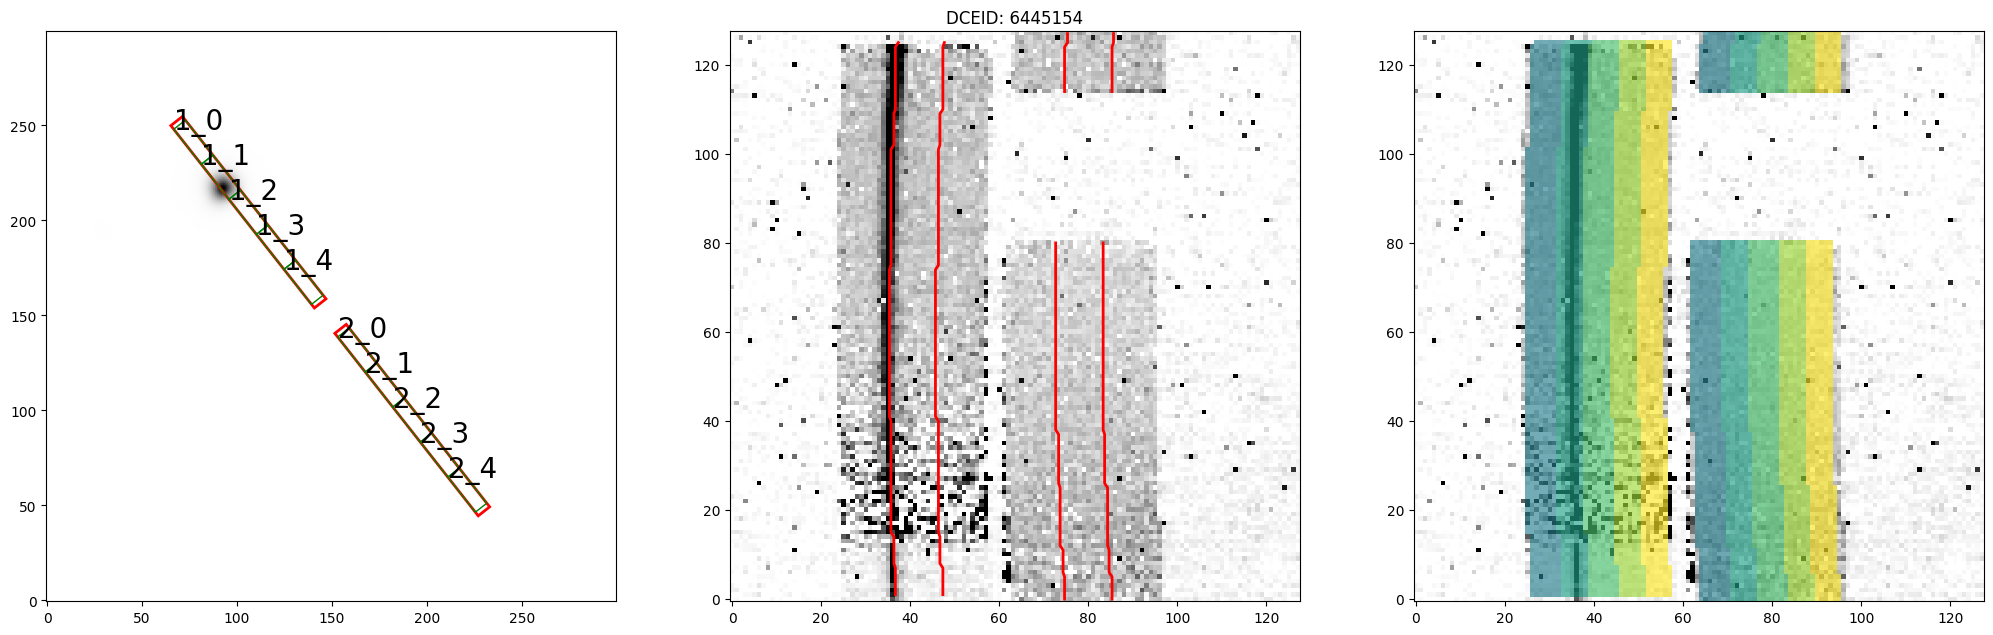

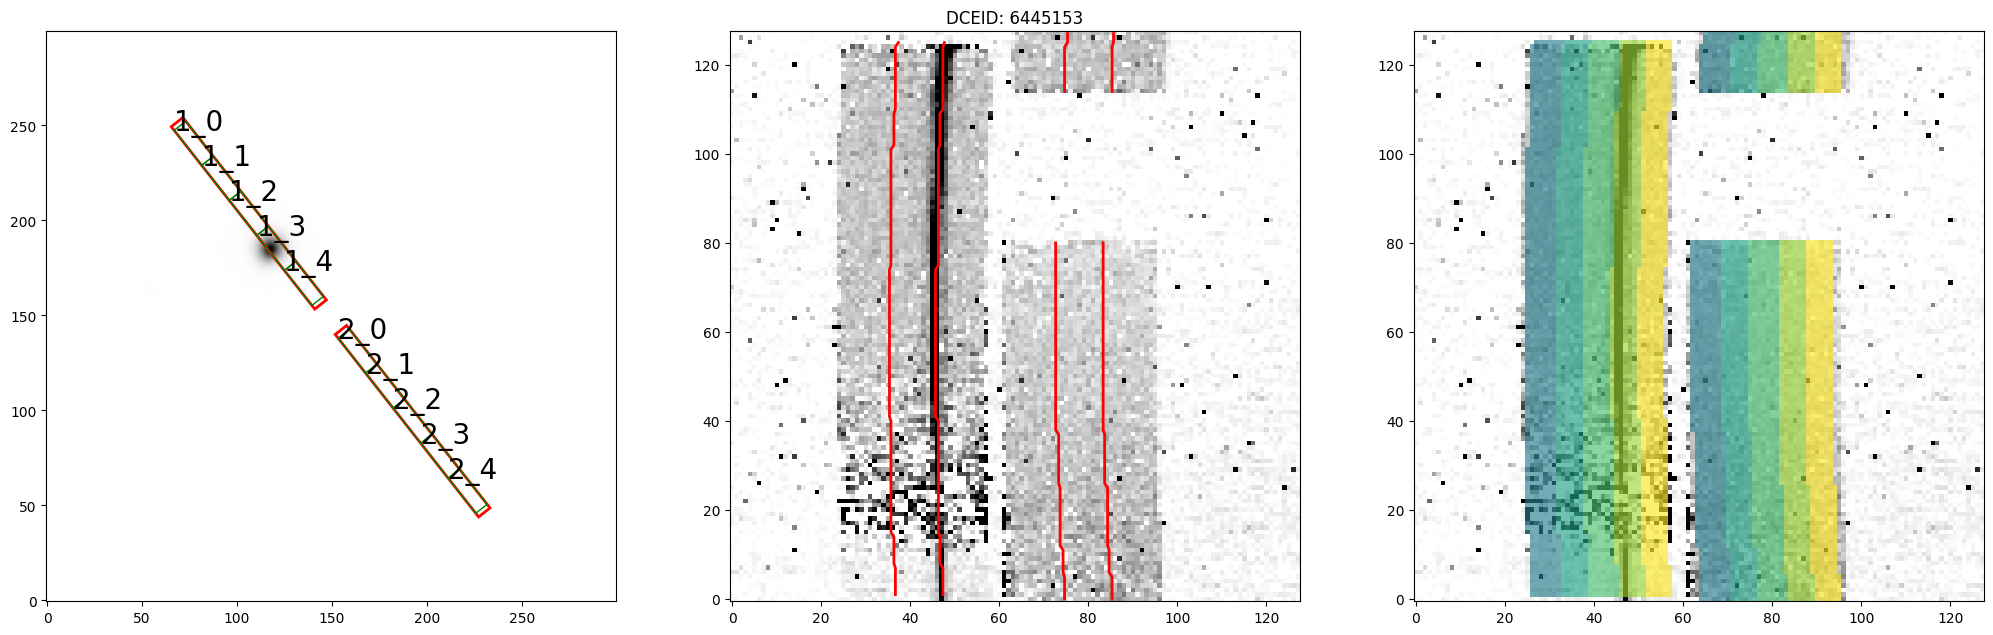

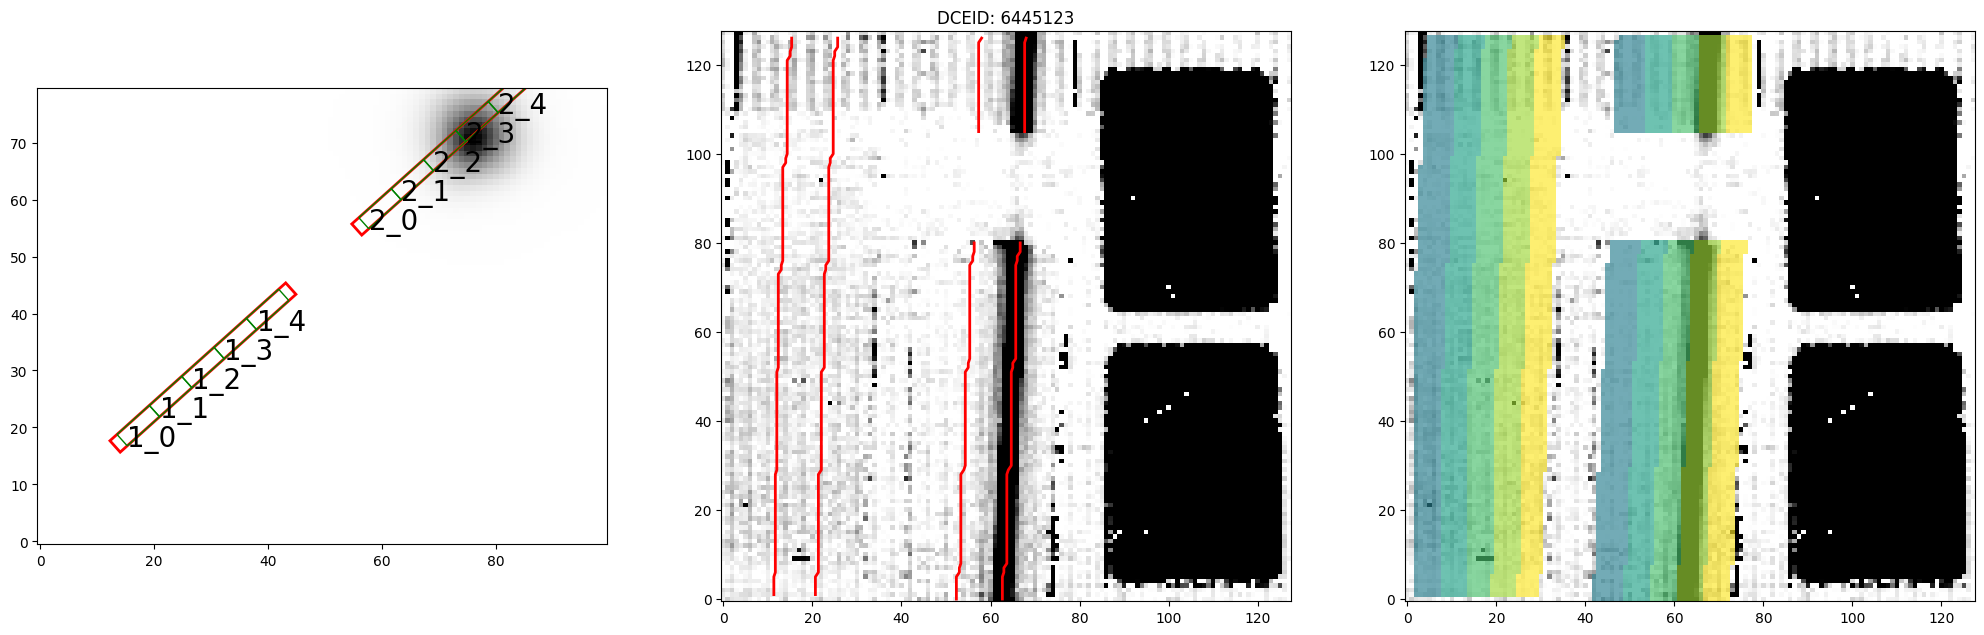

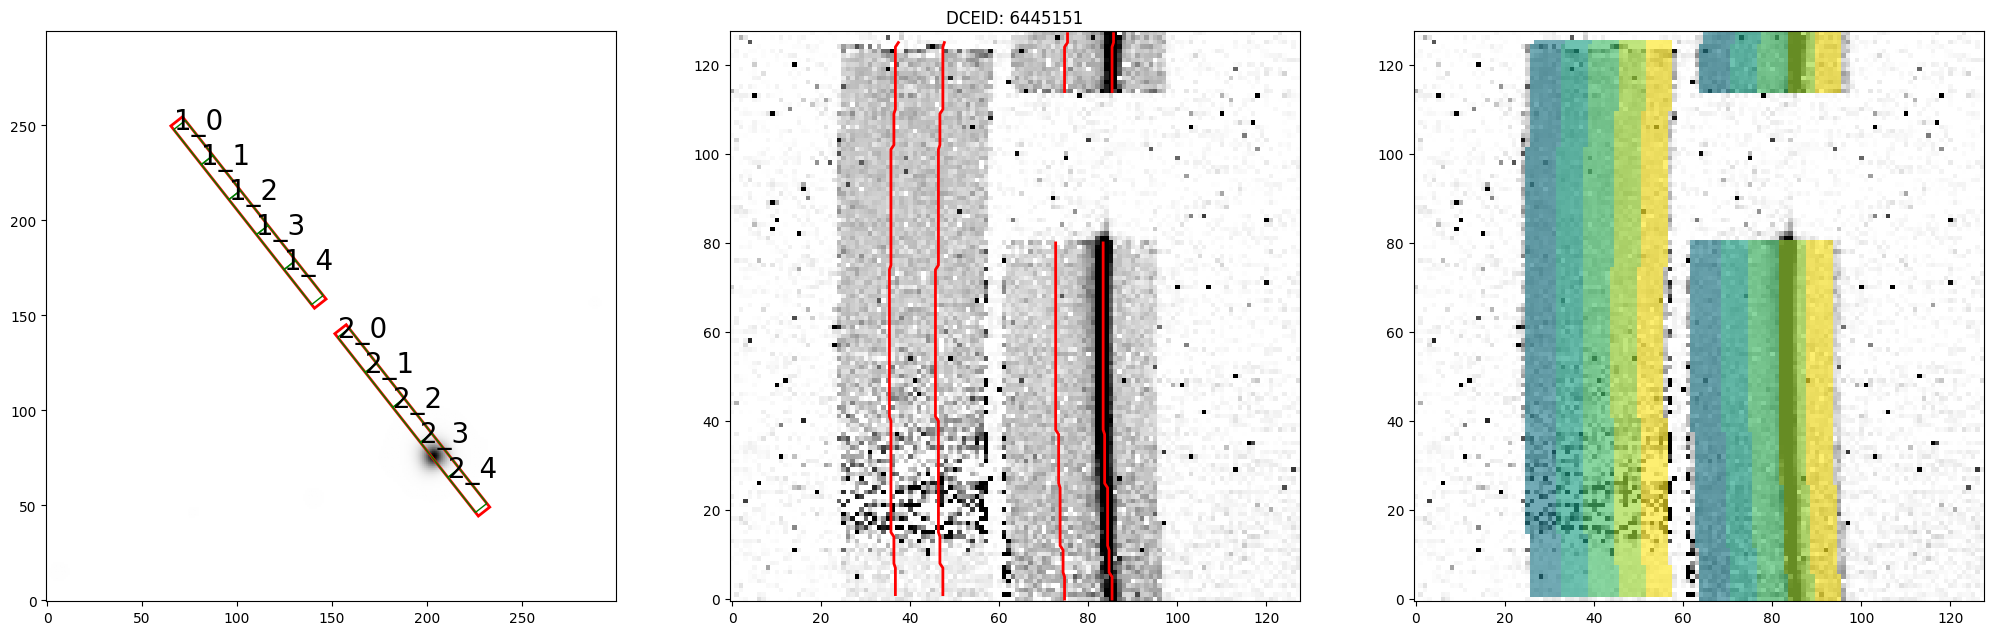

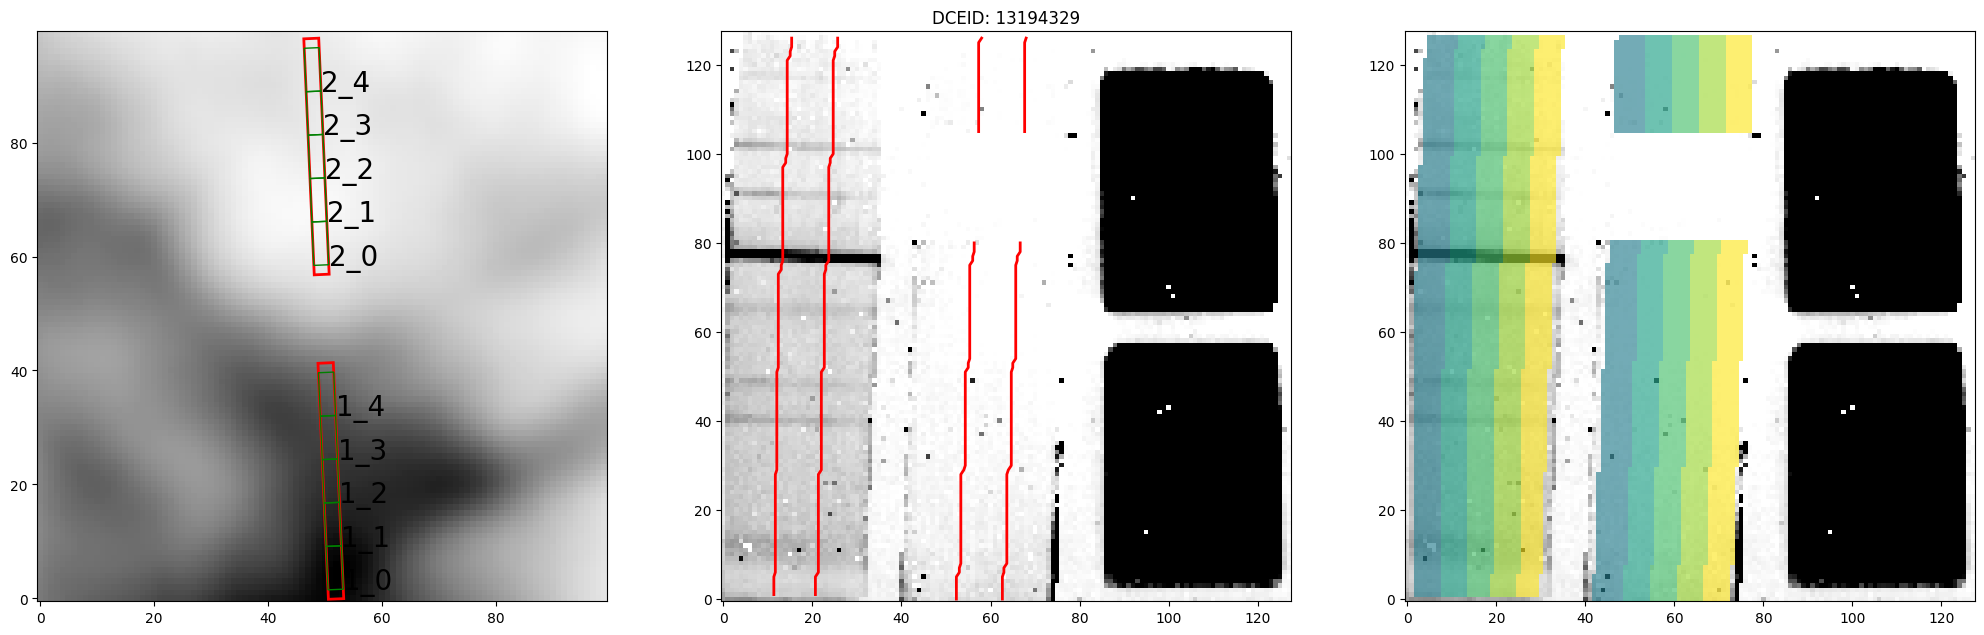

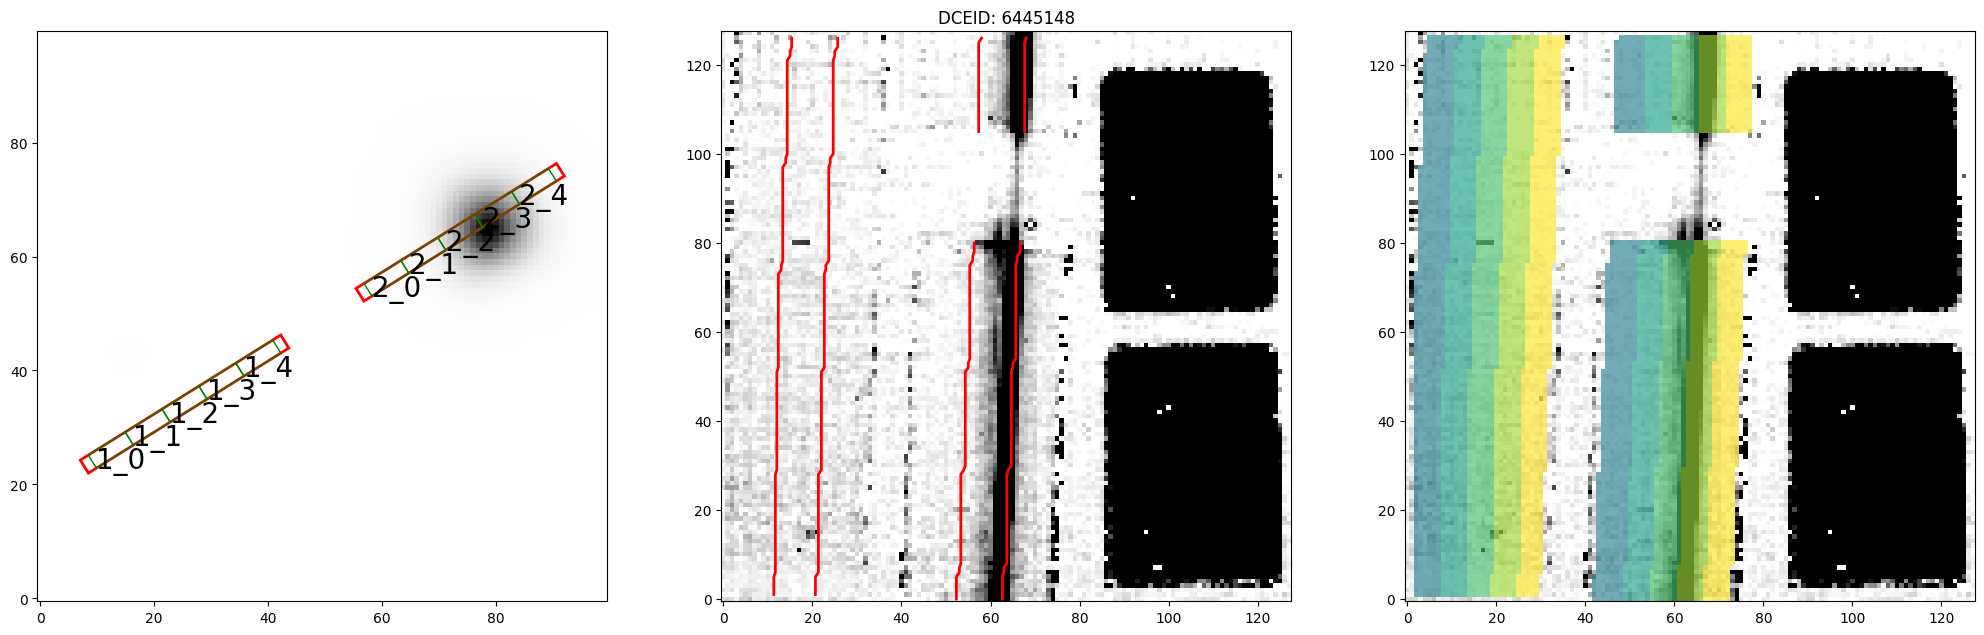

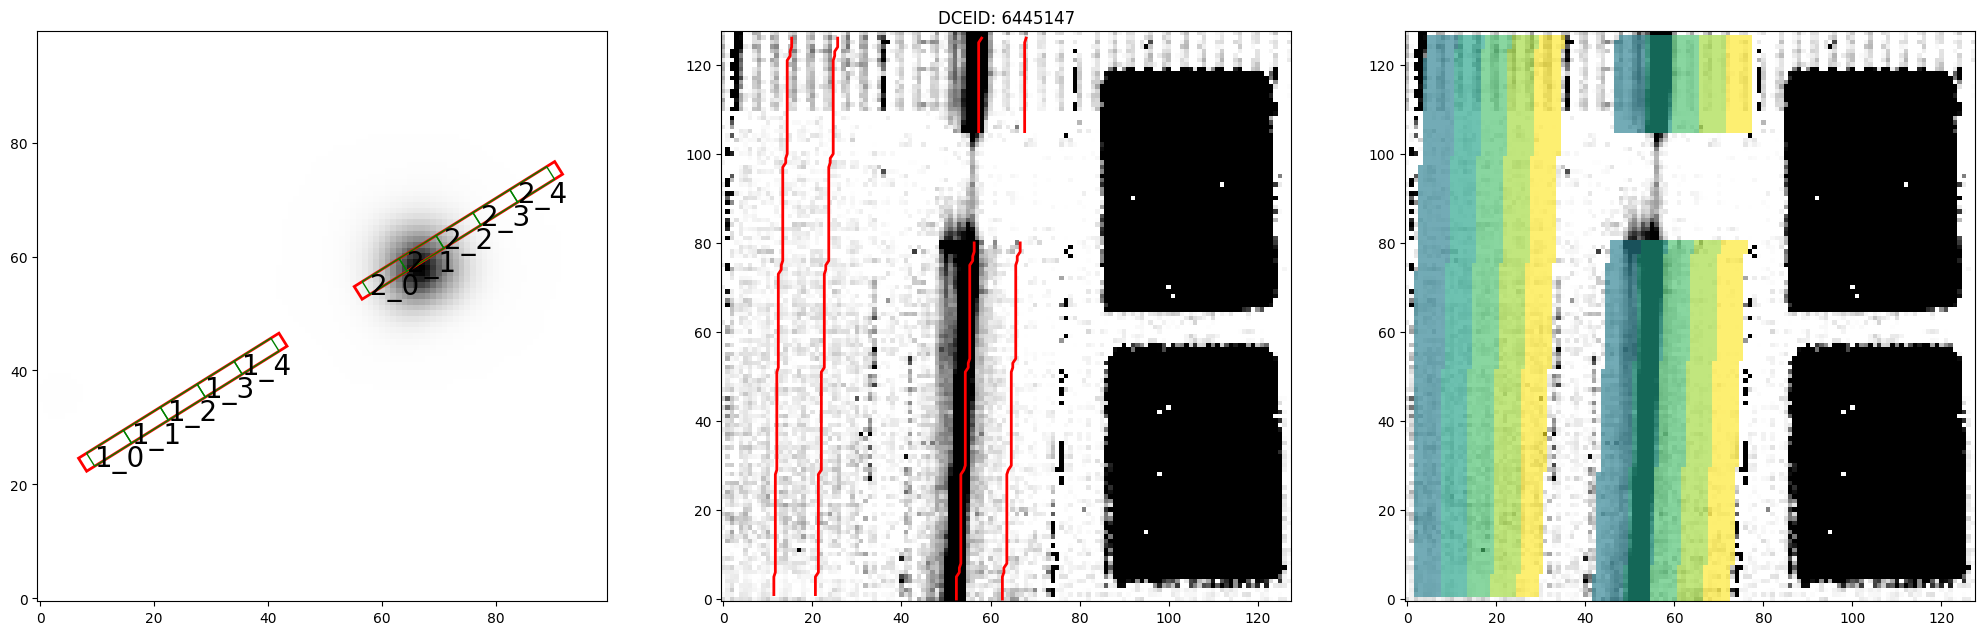

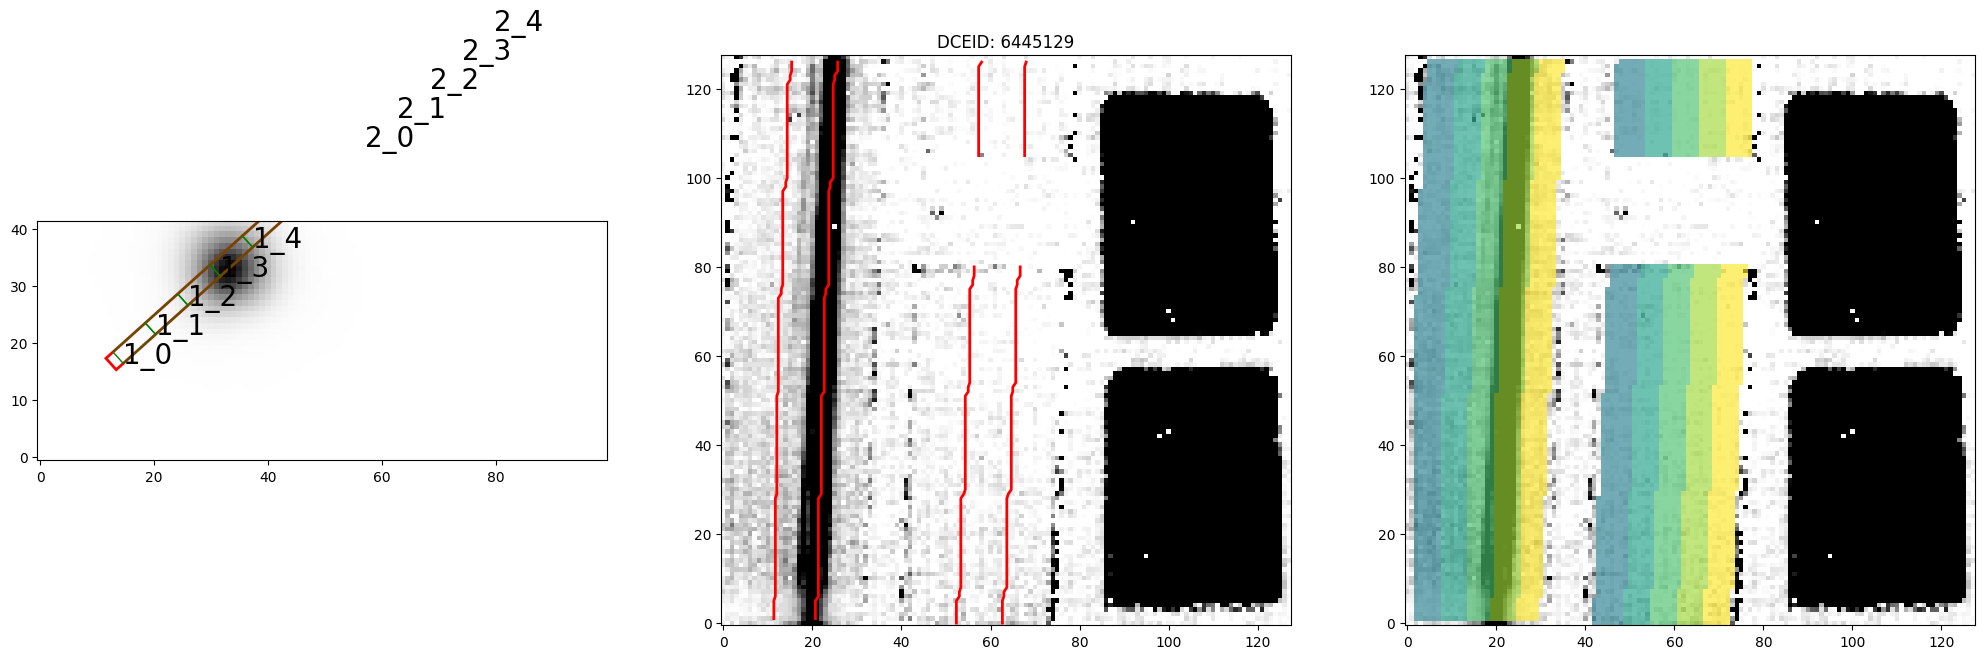

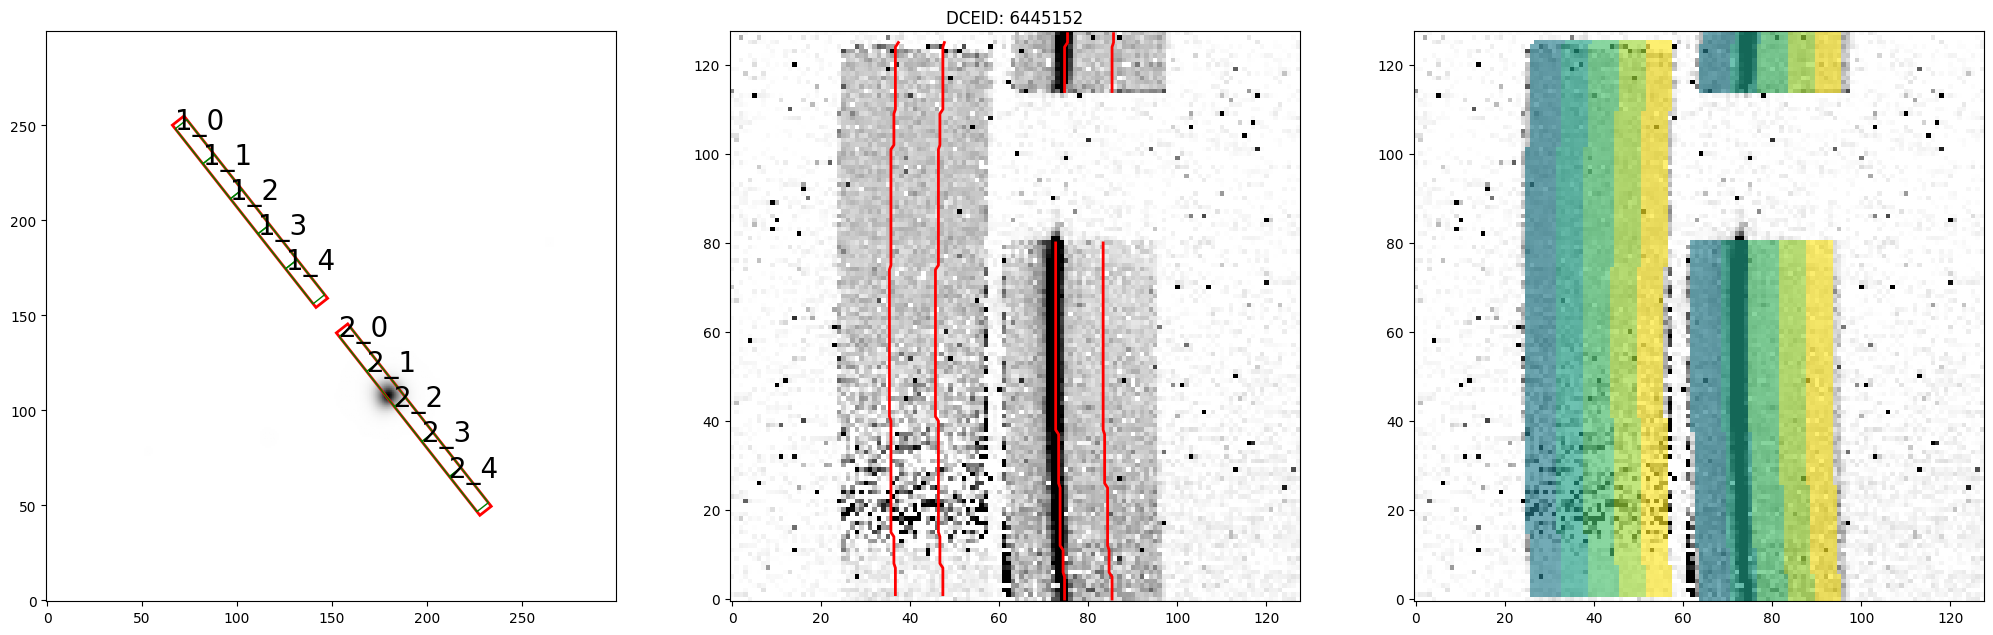

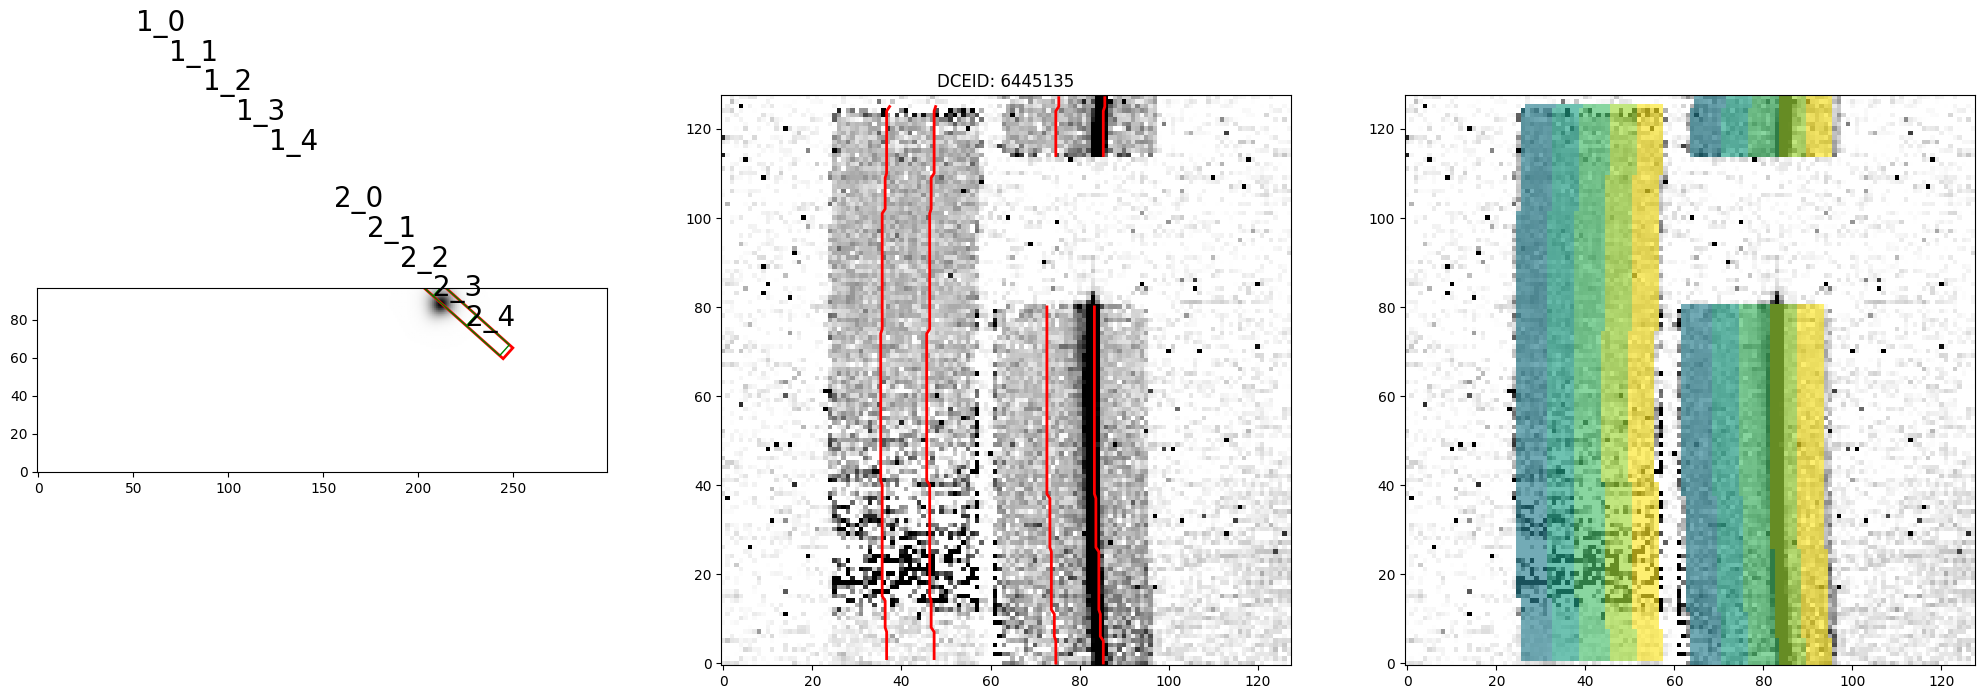

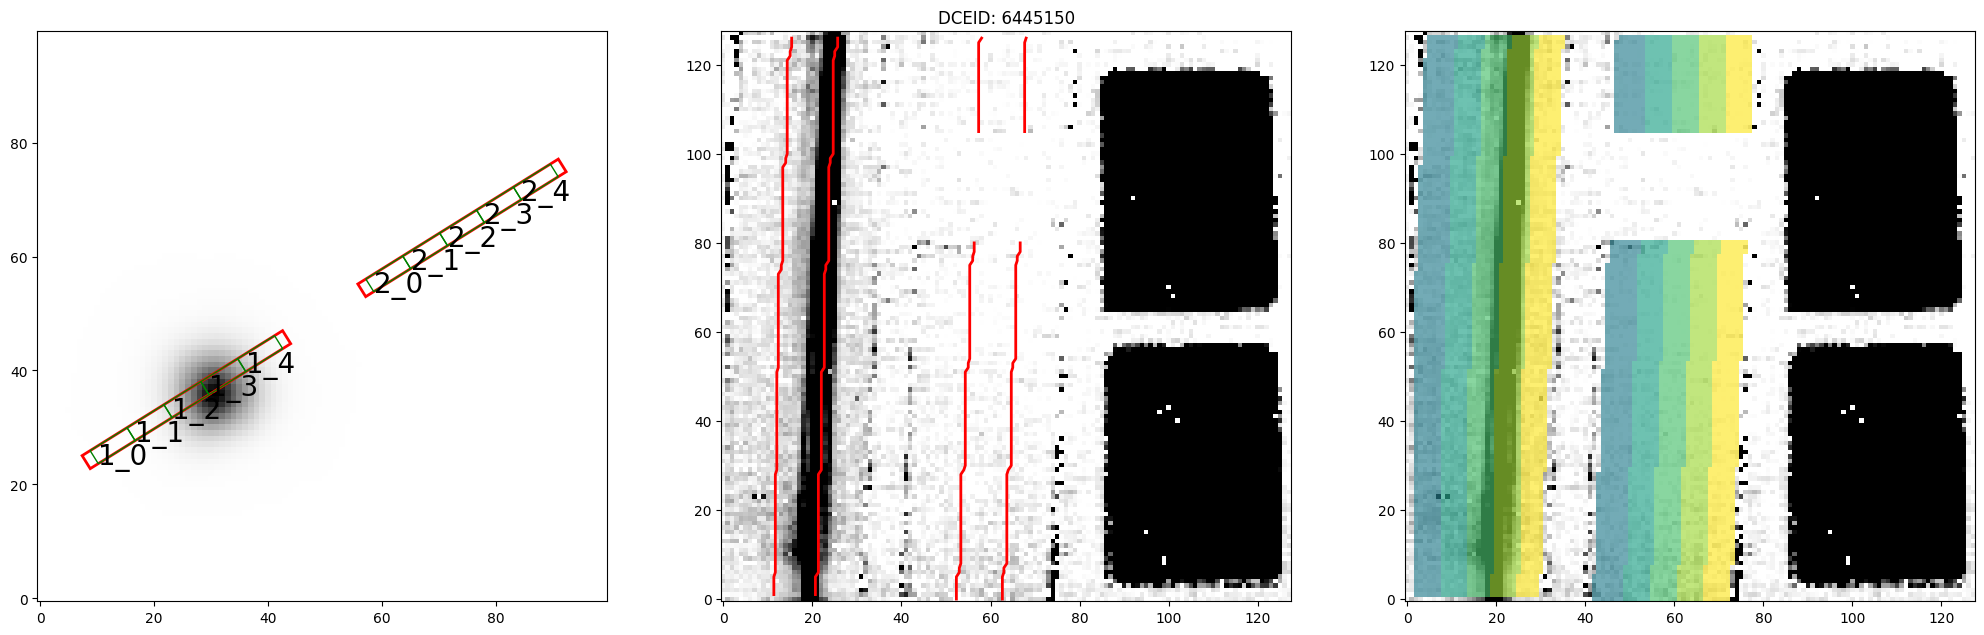

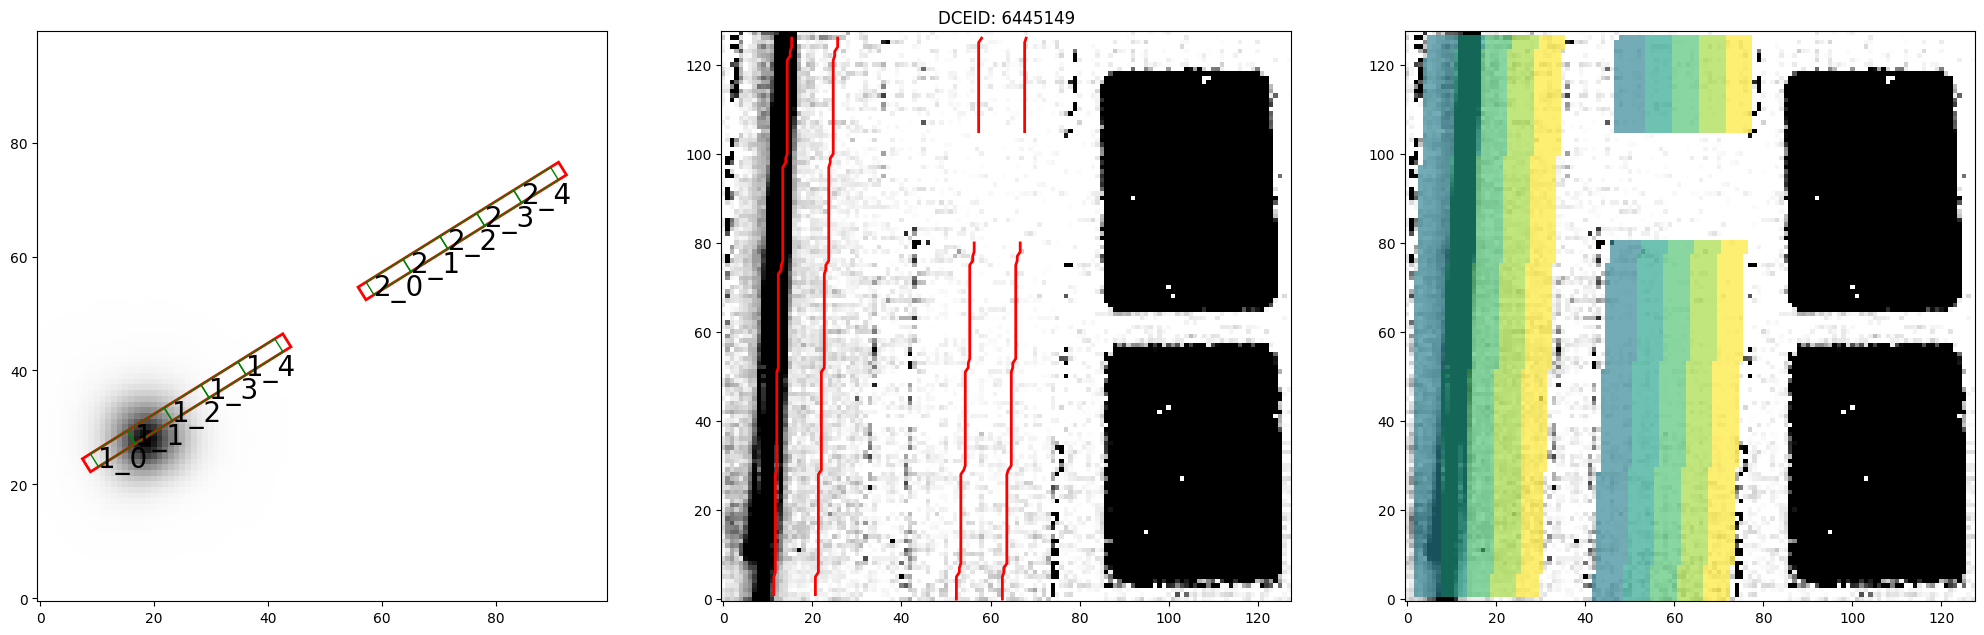

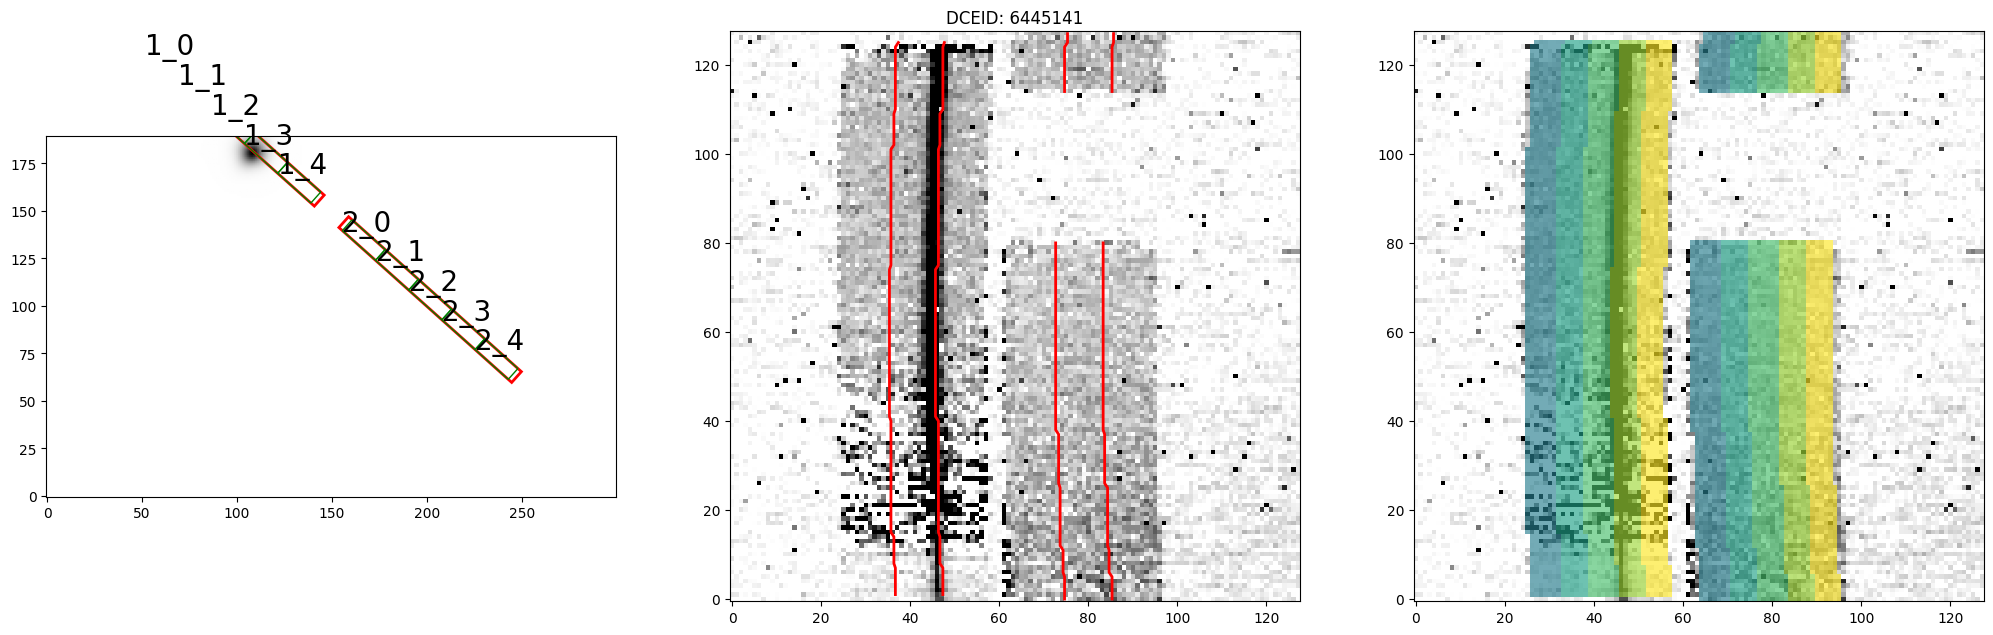

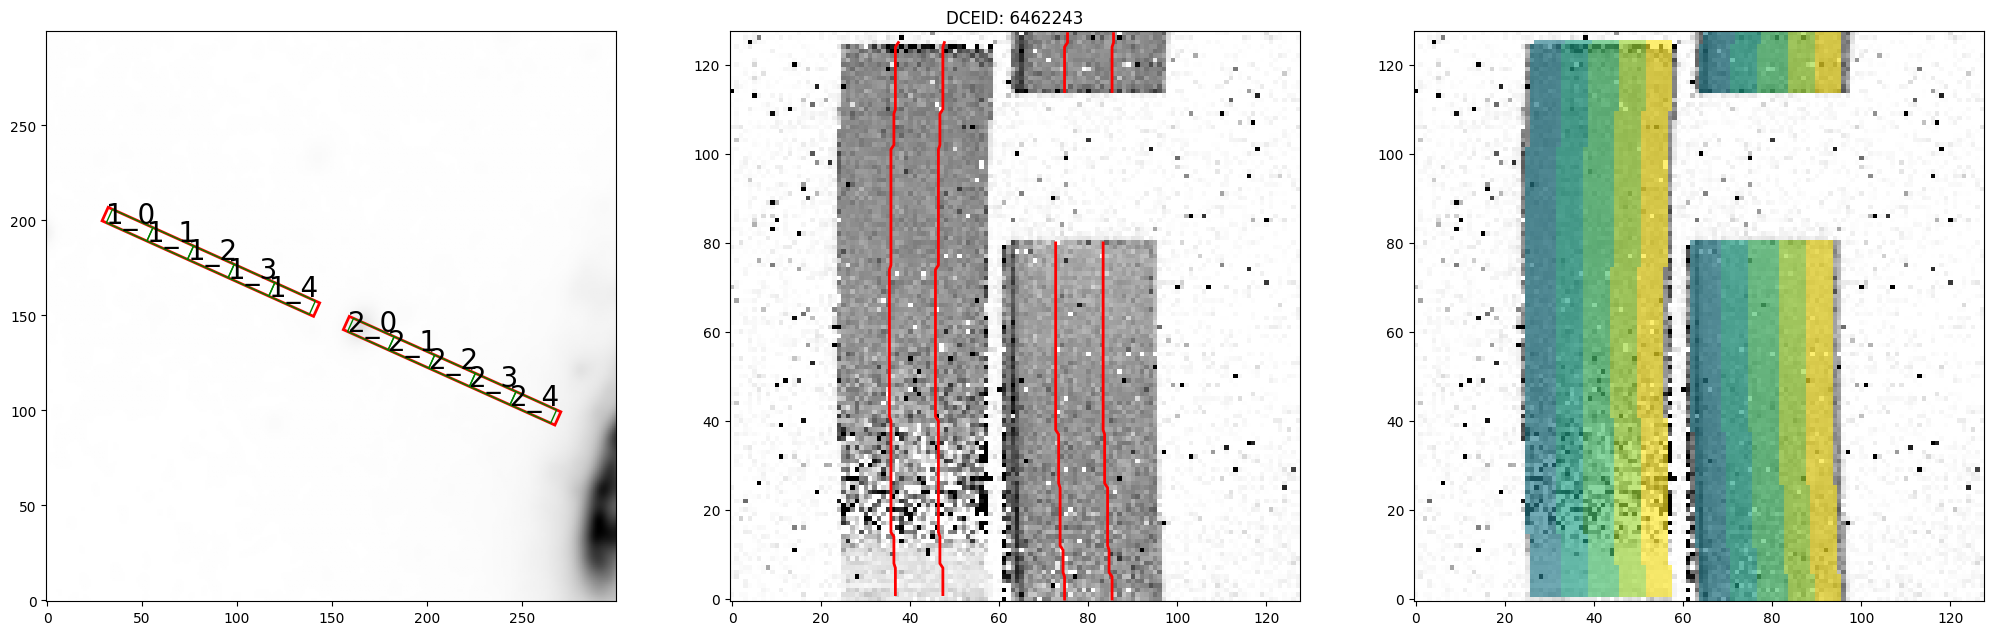

In [6]:
testbcds = glob.glob(simlapath+'storage/fovid_test/*.fits')

for bcd in testbcds:

    dceid = fits.getheader(bcd)['DCEID']
    
    q = query(simladb.select(DB_bcd.FILE_NAME, DB_bcd.CHNLNUM, DB_bcdwise.WISE_FILE, \
                             DB_shardpos.SUBORDER, DB_shardpos.SHARD, *scorners) \
                     .where(DB_bcd.DCEID==dceid))
    fname, chnl, wisefile, subs, shardids, corners = \
        irspath+q['FILE_NAME'][0], q['CHNLNUM'][0], wisepath+q['WISE_FILE'][0], \
        q['SUBORDER'].to_numpy(), q['SHARD'].to_numpy(), fmt_scorners(q)
    
    if chnl == 0: imsize = 100
    if chnl == 2: imsize = 300
    imdat, head, wcs = zoom_image([np.mean(corners.T[0]), np.mean(corners.T[1])], imsize, wisefile)
    
    fig, axs = plt.subplots(1, 3, figsize=(25, 10))
    
    plt.subplot(1, 3, 1)
    rectangles = validation_funcs.full_slit_position(fname)
    for rectangle in rectangles:
        pixel_rect = []
        for p in rectangle.region:
            sky_c = SkyCoord(p[0],p[1],unit='deg')
            pixel_p = astropy.wcs.utils.skycoord_to_pixel(sky_c, wcs)
            pixel_rect.append(pixel_p)
        poly = plt.Polygon(pixel_rect, edgecolor='red', facecolor='none', ls='-', lw=2) 
        axs[0].add_patch(poly)
    
    for c in range(len(corners)):
        rectangle = corners[c]
        pixel_rect = []
        for p in rectangle:
            sky_c = SkyCoord(p[0],p[1],unit='deg')
            pixel_p = astropy.wcs.utils.skycoord_to_pixel(sky_c, wcs)
            pixel_rect.append(pixel_p)
        poly = plt.Polygon(pixel_rect, edgecolor='green', facecolor='none', ls='-', lw=1) 
        axs[0].add_patch(poly)
        plt.text(pixel_rect[0][0], pixel_rect[0][1], str(subs[c])+'_'+str(shardids[c]), color='black', size=20)
        
    plt.imshow(imdat, cmap='gray_r', origin='lower')
    
    plt.subplot(1, 3, 2)
    bcddata = fits.getdata(bcd)
    plt.imshow(bcddata, origin='lower', vmin=0, vmax=100, cmap='gray_r')
    if chnl == 0:
        plt.plot(sl1_nods[1], sl1_nods[0], color='red', lw=2)
        plt.plot(sl1_nods[2], sl1_nods[0], color='red', lw=2)
        plt.plot(sl2_nods[1], sl2_nods[0], color='red', lw=2)
        plt.plot(sl2_nods[2], sl2_nods[0], color='red', lw=2)
        plt.plot(sl3_nods[1], sl3_nods[0], color='red', lw=2)
        plt.plot(sl3_nods[2], sl3_nods[0], color='red', lw=2)
    elif chnl == 2:
        plt.plot(ll1_nods[1], ll1_nods[0], color='red', lw=2)
        plt.plot(ll1_nods[2], ll1_nods[0], color='red', lw=2)
        plt.plot(ll2_nods[1], ll2_nods[0], color='red', lw=2)
        plt.plot(ll2_nods[2], ll2_nods[0], color='red', lw=2)
        plt.plot(ll3_nods[1], ll3_nods[0], color='red', lw=2)
        plt.plot(ll3_nods[2], ll3_nods[0], color='red', lw=2)
    plt.title('DCEID: '+str(dceid))
    
    plt.subplot(1, 3, 3)
    if chnl == 0: fullmask = sl_fullmask
    elif chnl == 2: fullmask = ll_fullmask
    plot = np.ones((128, 128))*fullmask
    for i in range([sl_n_shards, None, ll_n_shards][chnl]):
        shardmasks = np.load(simlapath+'calib/shard_masks/'+['SL',None,'LL'][chnl]+'1.npy')
        plot = np.where(shardmasks[i]==1, i+3, plot)
    for i in range([sl_n_shards, None, ll_n_shards][chnl]):
        shardmasks = np.load(simlapath+'calib/shard_masks/'+['SL',None,'LL'][chnl]+'2.npy')
        plot = np.where(shardmasks[i]==1, i+3, plot)
    for i in range([sl_n_shards, None, ll_n_shards][chnl]):
        shardmasks = np.load(simlapath+'calib/shard_masks/'+['SL',None,'LL'][chnl]+'3.npy')
        plot = np.where(shardmasks[i]==1, i+3, plot)
    plot = np.where(plot==0, np.nan, plot)
    plt.imshow(bcddata, origin='lower', vmin=0, vmax=100, cmap='gray_r')
    plt.imshow(plot, origin='lower', interpolation='none', vmin=0, alpha=0.65)
    
    plt.savefig(plotpath+'shard_masks/sky_vs_bcd_alignment_dceid'+str(dceid)+'.pdf', format='pdf')
    plt.show()